EVENTUAL TITLE OF MANUSCRIPT
============================
This notebook is the computational appendix of [arXiv:1605.XXXXX](http://arxiv.abs/1605.XXXXX). We spell out in detail how to obtain the numerical results in the manuscript. We rely on [Trotter-Suzuki-MPI](https://trotter-suzuki-mpi.github.io/), a massively parallel solver for the Gross--Pitaevskii equation, and its [Python wrapper](http://trotter-suzuki-mpi.readthedocs.org/). The calculations use only a single computer, but it can take many hours to finish them.

Preliminaries
-------------
First we import the necessary modules and ensure that we get identical behaviour in Python 2 and 3.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import trottersuzuki as ts
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from fractions import Fraction
import pandas
import time
from scipy.interpolate import spline, InterpolatedUnivariateSpline

We will generate some files to save the results of the calculations. By default, they will go the current directory:

In [ ]:
directory = ""

Precession of two vortices in a two-component BEC
-------------------------------------------------
The following function takes two parameters $l_{\Omega}/r_{12}$ and $R$, and returns $\Omega_{rot}/\Omega$. In the process, it sets up an imaginary time evolution to approximate the ground state of the system, and then performs real time evolution for a number of iterations that is necessary.

In [ ]:
def two_vortices(lOmega_over_r12, radius):
    ###
    #  Definition of variables and functions for the simulation
    ###
    
    ## Fixed variables
    length = 2. * radius                           # physical lenght of the lattice's side
    initial_vortices_distance = 1.0                # physical distance between vortices cores
    n_0 = 4 / (np.pi * length**2)                  # density at the center of the circular box
    if lOmega_over_r12 >= 0.5:                     # set r_{12} / \xi
        r12_over_Xi12 = 10.
    else:
        r12_over_Xi12 = 40.
    
    ### Lattice parameters
    const = 4.                                     # Ensure that one coherence length will be equal to "const" lattice spacings
    dim = int(length * const * r12_over_Xi12) + 1  # linear dimension of the lattice
    print('Linear dimension of the Lattice:', dim)
    
    ### Hamiltonian parameters
    g_a = 10. * r12_over_Xi12**2 / (2. * n_0) # intra-particle coupling (firt component)
    g_b = 10. * r12_over_Xi12**2 / (2. * n_0) # intra-particle coupling (second component)
    g_ab = 0                                  # inter-particle coupling
    omega_rabi = -1. / (lOmega_over_r12**2)   # Rabi coupling (it is negative since the library use a different sign convention)
    
    ### Solver parameters
    delta_t = 2.5e-5  # time for a single step evolution
    
    # Definition of the pinning potential (only for imaginary time evolution)
    gaussian_radius = 0.5/r12_over_Xi12
    gaussian_height = 100000
    
    def external_potential_imag_a(x, y):
        if (x**2 + y**2) >= (length/2.05)**2:
            return 1e10
        elif np.sqrt((x-1/2)**2+y**2) <= gaussian_radius:
            return gaussian_height*np.exp(- ((x-1/2)**2+y**2) / gaussian_radius**2) / (np.pi * gaussian_radius**2)
        else:
            return 0.
    
    def external_potential_imag_b(x, y):
        if (x**2 + y**2) >= (length/2.05)**2:
            return 1e10
        elif np.sqrt((x+1/2)**2+y**2) <= gaussian_radius:
            return gaussian_height*np.exp(- ((x+1/2)**2+y**2) / gaussian_radius**2) / (np.pi * gaussian_radius**2)
        else:
            return 0.
    
    # Definition of the circular well external potential (only for real time evolution)
    def external_potential(x, y):
        if (x**2 + y**2) >= (length/2.1)**2:
            return 1e10
        else:
            return 0.
    
    # Normalized initial state's wave function
    def const_state(x, y):
        return 1./length
    
    # Define the vortex in component 1
    def vortex_a(x, y):
        z = (x-initial_vortices_distance/2.) + 1j*y
        angle = np.angle(z)
        return np.exp(1j * angle)
    
    # Define the vortex in component 2
    def vortex_b(x, y):
        z = (x+initial_vortices_distance/2.) + 1j*y
        angle = np.angle(z)
        return np.exp(1j * angle)
    
    ###
    #  Set up of the simulation
    ###
    
    # Set the geometry of the simulation
    grid = ts.Lattice(dim, length)
    
    # Set the Hamiltonian
    potential_a = ts.Potential(grid)  # Set the pinning potential for the first component 
    potential_a.init_potential(external_potential_imag_a)
    potential_b = ts.Potential(grid)  # Set the pinning potential for the second component
    potential_b.init_potential(external_potential_imag_b)
    hamiltonian = ts.Hamiltonian2Component(grid, potential_a, potential_b, 1., 1.,
                                           g_a, g_ab, g_b, omega_rabi)
    
    # Set the initial state
    state_a = ts.State(grid)        # Initialize the state in the first component
    state_a.init_state(const_state)
    state_b = ts.State(grid)        # Initialize the state in the second component
    state_b.init_state(const_state)
    
    # Imprint the vortices on the corresponding components
    state_a.imprint(vortex_a)
    state_b.imprint(vortex_b)
    
    # Initialize the solver
    solver = ts.Solver(grid, state_a, state_b, hamiltonian, delta_t)
    
    ###
    #  Set up imaginary time evolution
    ###
    
    # Calculate initial vortices distance
    coord_a = ts.vortex_position(grid, state_a, length*0.45)
    coord_b = ts.vortex_position(grid, state_b, length*0.45)
    vortex_distance = np.sqrt((coord_b[0]-coord_a[0])**2 + (coord_b[1]-coord_a[1])**2)
    print('Vortices distance before imaginary evolution', vortex_distance)
    
    # Decide how many imaginary iterations to perform
    # NB: the higher the Rabi coupling, the higher the iterations needed to form the domain wall
    iterations = 1000
    if lOmega_over_r12 < .2:
        num = 1
    elif lOmega_over_r12 < .5:
        num = 4
    elif lOmega_over_r12 < 1.:
        num = 15
    else:
        num = 24
    print('Imaginary iterations between two snapshots:', iterations)
    
    # Start imaginary time evolution
    print('Imaginary time evolution started')
    for i in range(num):
        print(i+1, ' over ', num, ' completed')
        solver.evolve(iterations, True)         # Perform imaginary time evolution
    
    print('---Imaginary evolution completed---')
    
    # Calculate vortices distance after imaginary time evolution
    coord_a = ts.vortex_position(grid, state_a, length*0.45)
    coord_b = ts.vortex_position(grid, state_b, length*0.45)
    vortex_distance = np.sqrt((coord_b[0]-coord_a[0])**2 + (coord_b[1]-coord_a[1])**2)

    # Check whether the vortices distance has significantly changed and if true abort
    if np.abs(vortex_distance - initial_vortices_distance) > grid.delta_x:
        print('Vortices distance after imaginary time evolution:', vortex_distance, " THE SIMULATION WILL BE ABORTED")
        return
    else:
        print('Vortices distance has not significantly changed')
        print('Vortices distance after imaginary time evolution:', vortex_distance)
    
    ###
    #  Set up real time evolution
    ###
    
    # Change external potential to the circular wall without the pinning potential
    potential_a.init_potential(external_potential)
    potential_b.init_potential(external_potential)
    solver.update_parameters()    
    
    # Iterations to perform to get a tot_angle
    max_it_real_time = 20
    if lOmega_over_r12 < .5:
        iterations = 30
    elif lOmega_over_r12 < 1.:
        iterations = 8000
    else:
        iterations = 16000
        
    print('Iterations between two snapshots:', iterations)
    print('Number of snapshots:', max_it_real_time)
    
    angles_12 = []   # List of precession angles
    times = []       # List of times
    const_angle = 0. # Angle offset
    
    # Start real time evolution
    print('---Start real time evolution---')
    for cont in range(max_it_real_time):
        print('Snapshot:', cont)
        solver.evolve(iterations)
        
        # Calculate the precession angle of the vector r_12
        coord_a = ts.vortex_position(grid, state_a, length*0.45)  # Get position of the vortex in the first component
        coord_b = ts.vortex_position(grid, state_b, length*0.45)  # Get position of the vortex in the second component
        
        angles = np.angle(coord_a[0] - coord_b[0] + 1j * (coord_a[1] - coord_b[1])) # Calculate precession angle
        
        # Add an offset
        if cont > 2:
            last_angle = angles_12[len(angles_12)-2]
        else:
            last_angle = angles
        if abs(angles + const_angle - last_angle) > np.pi:
            const_angle += 2. * np.pi * np.sign(last_angle)
        
        angles_12.append(angles + const_angle)
        times.append(delta_t * iterations * (cont+1))
        
    ###
    #  Calculate precession frequency
    ###
    
    # fit angles curve
    fit_par = np.polyfit(times, angles_12, 1)  # fit_par[0] is the precession frequency
    
    # Print the results on screen
    print('l_omega/r12: ' + str(lOmega_over_r12))
    print('Mean freq of precession over Rabi coupling:', fit_par[0] / np.abs(omega_rabi))    
    
    return fit_par[0] / np.abs(omega_rabi)  # return \Omega_{rot} / \Omega

We explore the parameter space $l_{\Omega} / r_{12} \in [0.1, 10]$ and $R = 2, 3.5, 5$: 

In [ ]:
interval = np.linspace(-1,1,21)
parameters = [2, 3.5, 5]
df = pandas.DataFrame(index=range(len(interval)*len(parameters)), columns=["length_x", "l_omega_r12", "omega_rot/omega"], dtype=np.float64)
i = 0
time0 = time.time()
for lOmega_over_r12 in np.power(10, interval):
    for radius in parameters:
        time_i = time.time()
        df.iloc[i] = [2*radius, lOmega_over_r12, two_vortices(lOmega_over_r12, radius)]
        print("Execution time:", time.time()-time_i)
        i += 1
print("Total time:", time.time()-time0)

In [ ]:
plt.figure(figsize=(9,6))
colors = {4:"b", 7:"g", 10:"r"}

for radius in parameters:
    length_x = int(2*radius)
    ordered_left = df[(df['length_x'] == length_x) & (df['l_omega_r12'] <= 0.50118723) & (df['l_omega_r12'] != 0.79432823) & (df['l_omega_r12'] != 0.63095734)].sort('l_omega_r12')
    ordered_right = df[(df['length_x'] == length_x) & (df['l_omega_r12'] >= 0.50118723) & (df['l_omega_r12'] != 0.79432823) & (df['l_omega_r12'] != 0.63095734)].sort('l_omega_r12')
    x_l = ordered_left['l_omega_r12']
    y_l = ordered_left['omega_rot/omega']
    x_r = ordered_right['l_omega_r12']
    y_r = ordered_right['omega_rot/omega']
    x_rm = x_r.as_matrix()
    y_rm = y_r.as_matrix()
    x_r2 = np.linspace(x_rm.min(), x_rm.max(), 300)
    y_r2 = spline(x_rm, y_rm, x_r2)
    plt.plot(x_l,y_l, "--", dashes = [12,6], label="", color=colors[length_x])
    if length_x == 4:
        plt.plot(x_r2,y_r2, label=('$R/r_{12}=2$'), color=colors[length_x])
    if length_x == 7:
        plt.plot(x_r2,y_r2, label=('$R/r_{12}=3.5$'), color=colors[length_x])
    if length_x == 10:
        plt.plot(x_r2,y_r2, label=('$R/r_{12}=5$'), color=colors[length_x])


# add the strong coupling limit
x = np.linspace(0,2,100)
y = 4*np.sqrt(2)*x/np.pi
plt.plot(x,y,'-.', label="$\mathrm{strong} \, \mathrm{coupling}$");

# set labels and limits
plt.xscale('log')
plt.xlabel("$l_\Omega/r_{12}$")
plt.ylabel("$\Omega_\mathrm{rot}/\Omega$")
plt.xlim(0.1,10)
plt.ylim(-2,4)
plt.yticks([-2,-1,0,1,2,3,4], ['$-2$','$-1$','$0$','$1$','$2$','$3$','$4$'])
plt.xticks([0.1,1,10],['$10^{-1}$','$10^{0}$','$10^{1}$',])
#plt.grid(False)
plt.axhline(0, color='black',linewidth=1)
lgd = plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.);

plt.savefig("precession_frequencies.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

Plot figure 1b:

In [ ]:
plt.figure(figsize=(9,6))

for radius in parameters:
    length_x = int(2*radius)
    ordered = df[df['length_x'] == length_x].sort('l_omega_r12')
    x = 1. / (ordered['l_omega_r12'])**2
    y = x * ordered['omega_rot/omega']
    if length_x == 4:
        label='$R/r_{12}=2$'
    if length_x == 7:
        label='$R/r_{12}=3.5$'
    if length_x == 10:
        label='$R/r_{12}=5$'

    plt.plot(x,y, label=label, color=colors(length_x))
    # positions to inter/extrapolate
    xi = np.linspace(0, .25, 10)
    # spline order: 1 linear, 2 quadratic, 3 cubic ... 
    order = 1
    # do inter/extrapolation   (the data must be monotonously increasing)
    data_x = (np.array(x)[::-1])[:7]
    data_y = (np.array(y)[::-1])[:7]
    s = InterpolatedUnivariateSpline(data_x, data_y, k=order)
    yi = s(xi)
    # add the result for a single off-centered vortex in a cylindrical container; see Pethick&Smith, Chap.(9.4), Eq.(9.46)
    b=0.5;
    plt.plot([0], [1 / (((length_x/2)**2 - b**2))],'o', label="", markersize=10, color=colors(length_x))

# set labels and limits
plt.xlabel("$\Omega/\omega_{12}$")
plt.ylabel("$\Omega_\mathrm{rot}/\omega_{12}$")
plt.xlim(-0.02,.5)
plt.xticks([0.,.25,0.5], ['$0$','$0.25$', '0.5'])
plt.ylim(-.8,.4)
plt.yticks([-.6,-.3,0,.3], ['$-0.6$','$-0.3$','$0$','$0.3$']);
#plt.grid(False)
plt.axhline(0, color='black',linewidth=1);
plt.axvline(0, color='black',linewidth=1);

lgd = plt.legend(bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.);

plt.savefig("precession_frequencies_2.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

Transfer of a single vortex between a two-component BEC
-------------------------------------------------------
First we define some helper functions. The following are used to compute the trajectories' angle

In [2]:
def cut_trajectories(allTrajectories, minLengthTraj):
    trajectoriesList = [[] for i in range(2)]  # trajectoriesList[0] holds the x-coordinates, trajectoriesList[1] holds the y-coordinates
    for i in range(0, 2):
        indexNan = np.where(np.isnan(allTrajectories[i]) == True)[0]  # Get position of NaN items in allTrajectories[i]
        start = 0
        for j in range(0, len(indexNan)):
            if indexNan[j] - start == 0:
                start += 1
            elif indexNan[j] - start > minLengthTraj:
                trajectoriesList[i].append(allTrajectories[i][start:indexNan[j]])
                start = indexNan[j] + 1
    
    return trajectoriesList

def parabola(x,a,phi):
        return a*(x[1]*np.cos(phi) - x[0]*np.sin(phi))**2  - x[0]*np.cos(phi) - x[1]*np.sin(phi) 

def get_trajectory_angle(trajX, trajY, method='vector'):
    trajX = trajX[np.logical_not(np.isnan(trajX))]  # Drop NaN items
    trajY = trajY[np.logical_not(np.isnan(trajY))]  # Drop NaN items
    if method == 'vector':
        x = 0.
        y = 0.
        for i in range(0, len(trajX)):
            x += trajX[i]
            y += trajY[i]
        
        z = x + 1j*y
        return np.angle(z)
    else:
        trajXY = np.array([trajX, trajY])
        zeros_list = trajX * 0.    
        popt, pcov = curve_fit(parabola, trajXY, zeros_list)  # fit the trajectory with a parabola
        return popt[1] + (0. if popt[0] >= 0. else -np.pi)
    
    

The simulation is performed by the following function:

In [53]:
def single_vortex(dim, Rabi_period, coupling, Rabi_periods_to_be_simulated, gAB_over_g, 
                  densities1, densities2, phases1, phases2, coord1x, coord1y, coord2x, coord2y):
    
    TF_radius = (4*coupling/np.pi)**0.25
    length = np.array([6,np.ceil(4*TF_radius)]).max()  # physical length of the lattice
    grid = ts.Lattice(dim, length)
    
    ## Define the Hamiltonian
    potential = ts.HarmonicPotential(grid, 1., 1.)
    
    g1 = coupling
    g2 = coupling
    g12 = gAB_over_g * coupling
    omega = 0
    hamiltonian = ts.Hamiltonian2Component(grid, potential, potential, 1., 1., g1, g12, g2, omega)
    
    
    ## Define the initial state
    width = max(TF_radius,1)
    w = 0.5 / width**2
    state1 = ts.GaussianState(grid, w)
    state2 = ts.GaussianState(grid, w)
    
    ## Imprint(vortex phase
    def vortex_phase(x, y):
        z = x + 1j*y
        angle = np.angle(z)
        return np.exp(1j * (angle))
    
    state1.imprint(vortex_phase)
    
    
    ## Initialize the solver
    frames_per_Rabi_period = 30
    real_iterations = 700  # number of iterations performed by each instance of ts
    deltaT = Rabi_period /(real_iterations * frames_per_Rabi_period)
    
    solver = ts.Solver(grid, state1, state2, hamiltonian, deltaT)
    
    #################################################################
    ## IMAGINARY EVOLUTION
    print("Start imaginary-time evolution")
    iterations = 2000
    NumEvo = 4
    for i in range(0, NumEvo):
        solver.evolve(iterations, True)
        print('Energy', solver.get_total_energy(), '  kinetic energy:', solver.get_kinetic_energy())
    
    #################################################################
    ## REAL-TIME EVOLUTION
    omega = -2*np.pi / Rabi_period
    hamiltonian.omega_r = omega  # Switch on the Rabi coupling
    solver.update_parameters
    
    iterations = real_iterations
    NumEvo = int(frames_per_Rabi_period * Rabi_periods_to_be_simulated)  # number of frames to be included in the movie
    
    coord1 = ts.vortex_position(grid, state1, width).reshape((2,1))
    coord2 = ts.vortex_position(grid, state2, width).reshape((2,1))
    
    ### coherence length of BEC_A
    xi_B=1./np.sqrt(2 * g2 * state2.get_particle_density().max())
    xi_A=xi_B
    
    densities1.append(state1.get_particle_density())
    densities2.append(state2.get_particle_density())
    phases1.append(state1.get_phase())
    phases2.append(state2.get_phase())
    coord1x.append(coord1[0])
    coord1y.append(coord1[1])
    coord2x.append(coord2[0])
    coord2y.append(coord2[1])
    
    angle1_list = []
    angle2_list = []
    N1 = []
    N2 = []
    N_tot = []
    N1.append(sum(sum(state1.get_particle_density())) * (grid.delta_x*grid.delta_x))
    N2.append(sum(sum(state2.get_particle_density())) * (grid.delta_x*grid.delta_x))
    N_tot.append(N1[len(N1)-1]+N2[len(N1)-1])
    for i in range(0, NumEvo):
        solver.evolve(iterations)
        if i+1 == frames_per_Rabi_period//2 or i+1 == frames_per_Rabi_period:
            densities1.append(state1.get_particle_density())
            densities2.append(state2.get_particle_density())
            phases1.append(state1.get_phase())
            phases2.append(state2.get_phase())
            coord1x.append(coord1[0])
            coord1y.append(coord1[1])
            coord2x.append(coord2[0])
            coord2y.append(coord2[1])

    
        _coord1 = ts.vortex_position(grid, state1, width).reshape((2,1))
        _coord2 = ts.vortex_position(grid, state2, width).reshape((2,1))
        coord1 = np.concatenate((coord1, _coord1.reshape((2,1))), axis=1)
        coord2 = np.concatenate((coord2, _coord2.reshape((2,1))), axis=1)
        print(i)
        
            
    ################################################################
    ## Trajectories analysis
    maxNanItems = 4  # Maximum number of contiguous Nan items allowed in a trajectory
    trajectories1 = cut_trajectories(coord1, maxNanItems)  # get the list of trajectories in condensate 1
    trajectories2 = cut_trajectories(coord2, maxNanItems)  # get the list of trajectories in condensate 2
    # trajectories1[0][i] holds an array of x-coordinates of the i-th trajectory in condensate 1
    # trajectories1[1][i] holds an array of y-coordinates of the i-th trajectory in condensate 1
    # It may contain NaN items
    
    angle1 = [0.]
    angle2 = []
    for i in range(1, len(trajectories1[0])):
        angle1.append(get_trajectory_angle(trajectories1[0][i], trajectories1[1][i])) # list of trajectories's angle in condensate 1
    for i in range(0, len(trajectories2[0])):    
        angle2.append(get_trajectory_angle(trajectories2[0][i], trajectories2[1][i])) # list of trajectories's angle in condensate 2
    
    return coord1, coord2, angle1, angle2
    

Coherent quantum phase slip is shown in the following simulation.

In [54]:
densities1 = []
densities2 = []
phases1 = []
phases2 = []
coord1x = []
coord1y = []
coord2x = []
coord2y = []
    

# linear size of the lattice
dim=100

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 2

# start evolution
gAB_over_g =1.
Rabi_period = np.pi
coupling = 20.
coord1, coord2, angle1, angle2 = single_vortex(dim, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                               gAB_over_g, densities1, densities2, phases1, phases2, coord1x, coord1y, coord2x, coord2y)



Start imaginary-time evolution
Energy 5.12276505079   kinetic energy: 0.672257201357
Energy 4.77855439561   kinetic energy: 0.765085013299
Energy 4.71784829042   kinetic energy: 0.805356589994
Energy 4.70655841211   kinetic energy: 0.822344659723
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


We plot the densities and phases of the two components and superimpose the trajectory of the vortex's core:

In [33]:
fig = plt.figure(figsize=(18,12.7));
for row in range(0,3):
    cont = row*10
    
    fontsi = 23
    rescale = 0.65
    markersize = 90
    
    imag_time =  False
    
    
    dim_x_ = 150
    length_x_ = 9.
    delta_x = length_x_ / dim_x_
    
    TF_radius_ = 2.24638933492
    Rabi_period = np.pi
    Omega_Rabi = 2.*np.pi/Rabi_period
    g_A = 20.
    g_B = g_A
    g_AB = g_A
    xi_A = 0.434474936715
    
    frames_per_Rabi_period = 20
    real_iterations = 700  # number of iterations performed by each instance of ts
    deltaT = Rabi_period /(real_iterations * frames_per_Rabi_period)
    time = deltaT*(cont)*real_iterations
    
    # rescaling of the pcolor plots
    dim_x = int(dim_x_ * rescale / 2.) *2
    rescale_ = dim_x / (dim_x_ * 1.)
    length_x = length_x_ * rescale_
    TF_radius = TF_radius_ * rescale_ 
    
    density_A_ = densities1[row]
    density_B_ = densities2[row]
    phase_A_ = phases1[row]
    phase_B_ = phases2[row]
    
    edge = int((dim_x_ - dim_x) / 2)
    density_A = density_A_[edge:dim_x_-edge, edge:dim_x_-edge]
    density_B = density_B_[edge:dim_x_-edge, edge:dim_x_-edge]
    phase_A = phase_A_[edge:dim_x_-edge, edge:dim_x_-edge]
    phase_B = phase_B_[edge:dim_x_-edge, edge:dim_x_-edge]
    
    _coord1x = coord1x[row]
    _coord1y = coord1y[row]
    _coord2x = coord2x[row]
    _coord2y = coord2y[row]
    
    # vectors containing the physical coordinates (in h.o. units, and centered in the lattice)
    x_vec = y_vec = (np.arange(dim_x) - dim_x*0.5) * delta_x
    
    # draw a mask around the phase pattern, with a radius slightly larget than the TF radius
    # set the first pixel to -pi, and the second to +pi
    # (so the range of plotting is fixed, and the mask doesn't change color)
    
    approx_cloud_radius = max(TF_radius_,1)
    disk_mask = np.zeros((dim_x, dim_x))
    for ix in range(0, dim_x):
        for iy in range(0, dim_x):
            if ((ix-dim_x*0.5)**2 + (iy-dim_x*0.5)**2) > (1.25 * (2*approx_cloud_radius/length_x) * dim_x / 2)**2:
                disk_mask[ix,iy] = 0.99
    disk_mask = np.ma.masked_where(disk_mask < 0.5, disk_mask)
    
    phase_A[0,0]=-np.pi
    phase_B[0,0]=-np.pi
    phase_A[0,1]=np.pi
    phase_B[0,1]=np.pi
    
    
    #################################################################
    # Make plot
    
    ###################
    
    # Strong coupling
    X, Y = np.meshgrid(x_vec, y_vec)
    U = np.sqrt(X**2 + Y**2)/TF_radius_
    
    ###max_density = np.array([density_A.max(),density_B.max()]).max()   # maximum of the two densities
    # here I have set the particle mass to 1
    N_A=N_B=1
    c = 4./3 - 128/(45*np.pi)
    # in the following, I have used hbar=m=1
    Z_A =( (1-U**2) * (2 * np.log(TF_radius_/xi_A) + np.log(1-U**2)) + 2*U**2 - 1 
         +  Omega_Rabi * TF_radius_**2 * np.sqrt(N_B/N_A) * np.absolute(4*U/3 - c*U**3) * np.cos(np.angle(X+1.0j*Y)) ) 
        
    ###################
    
    data=[density_A,density_B,phase_A,np.remainder(phase_A-phase_B+np.pi,2*np.pi)]
    
    x_centers=[_coord1x, _coord2x, _coord1x, _coord2x]
    y_centers=[_coord1y, _coord2y, _coord1y, _coord2y]
    cmaps=['afmhot','afmhot','hsv','hsv']
    
    norm = colors.Normalize(vmin = 0., vmax = 1.)
    
    for i in np.arange(len(data)):
        ax = plt.subplot(3,4,i+1+row*4)
        if i == 0:
            marker = 'o'
            subplot_title = "$n_1$"
        elif i == 1:
            marker = 'D'
            subplot_title = "$n_2$"
        elif i == 2:
            marker = 'o'
            subplot_title = "$\phi_1$"
        else:
            marker = 'D'
            marker2 = 'o'
            subplot_title = "$\phi_1 - \phi_2 \, \mathrm{mod} \, 2 \pi$"
        if row == 0:
            ax.set_title(subplot_title, fontsize=fontsi, va='bottom')

        x_ticks_1, x_ticks_2=[dim_x/2 - int(TF_radius_/delta_x), dim_x/2 - int(TF_radius_/(2*delta_x)), dim_x/2, dim_x/2 + int(TF_radius_/(2*delta_x)), dim_x/2 + int(TF_radius_/(delta_x))], ['','','','', '']
        y_ticks_1, y_ticks_2=[dim_x/2 - int(TF_radius_/delta_x), dim_x/2 - int(TF_radius_/(2*delta_x)), dim_x/2, dim_x/2 + int(TF_radius_/(2*delta_x)), dim_x/2 + int(TF_radius_/(delta_x))], ['$'+str(-1)+'$', '$'+str(-0.5)+'$', '$0$', '$'+str(0.5)+'$', '$'+str(1)+'$']    
        if cont == 20:
            plt.xlabel('$x/R$', fontsize=fontsi)
            plt.xticks(y_ticks_1,y_ticks_2, fontsize=fontsi)
            if i==0:
                plt.ylabel('$y/R$', fontsize=fontsi)
                plt.yticks(y_ticks_1,y_ticks_2, fontsize=fontsi)
            else:
                plt.yticks(x_ticks_1,x_ticks_2, fontsize=fontsi)
        else:
            plt.xticks(x_ticks_1,x_ticks_2, fontsize=fontsi)
            if i==0:
                plt.ylabel('$y/R$', fontsize=fontsi)
                plt.yticks(y_ticks_1,y_ticks_2, fontsize=fontsi)
            else:
                plt.yticks(x_ticks_1,x_ticks_2, fontsize=fontsi)
        ##############
         
        plt.pcolormesh(data[i],cmap=cmaps[i],linewidth=0,rasterized=True)
        
        #plot mask
        if i >= 2:
            plt.pcolor(disk_mask, cmap='Greys_r',linewidth=0,rasterized=True)
        #plot trajectories    
        color_indices=np.linspace(0, 1, _coord1x.size) * _coord1x.size / 20.
        scatter_plot = plt.scatter(x_centers[i] / delta_x + 0.5*dim_x, y_centers[i] / delta_x + 0.5*dim_x,\
                    c=color_indices, cmap='Greys_r', norm=norm,s=markersize, edgecolors='Green', marker=marker)
        if i==3:
            plt.scatter(x_centers[2] / delta_x + 0.5*dim_x, y_centers[2] / delta_x + 0.5*dim_x,\
                    c=color_indices, cmap='Greys_r', norm=norm,s=markersize, edgecolors='Green', marker=marker2)
        
        if cont == 0:
            plt.scatter([dim_x/2 - int(2./delta_x)], [dim_x/2 - int(2./delta_x)], s=0.01)
            if i == 0:
                plt.contour(Z_A, linewidths=2) 


cbaxes = fig.add_axes([0.93,0.073,0.015,0.875]) #20: [0.92,0.23,0.015,0.735], for the others: [0.92,0.04,0.015,0.92]
cbar = plt.colorbar(scatter_plot, cax = cbaxes, ticks = [0,0.5,1], format='$%1.1f$')
cbar.ax.tick_params(labelsize=fontsi)
cbar.set_label(r'$t/T$', labelpad=5,y=0.5, fontsize=fontsi)
cbar.ax.invert_yaxis()

plt.tight_layout(rect=(0,0,0.92,0.995))
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:90: RuntimeWarning: invalid value encountered in log


In the following we see that the vortex core performs a trajectory which is the one that preserve the energy given by equation (), but with a further rotation of the polar angle:

In [51]:
fontsize = 16

TF_radius = 2.24638933492
xi_A = 0.43429342721
xi_B = 0.43429342721

Rabi_period = np.pi
Omega_Rabi = 2*np.pi / Rabi_period

const = .5
frame_per_period = 30

time = np.linspace(0,Rabi_periods_to_be_simulated, Rabi_periods_to_be_simulated*frame_per_period, endpoint=False) * Rabi_period
phi_bar = time * const

########################
N_A=N_B=1
c = 4./3 - 128/(45*np.pi)

x = np.delete(coord1[0], len(coord1[0])-1)
y = np.delete(coord1[1], len(coord1[1])-1)
u = np.sqrt(x**2 + y**2) / TF_radius
Z_A_v =( (1-u**2) * (2 * np.log(TF_radius/xi_A) + np.log(1-u**2)) + 2*u**2 - 1 
    +  Omega_Rabi * TF_radius**2 * np.sqrt(N_B/N_A) * np.absolute(4*u/3 - c*u**3) * np.cos(np.angle(x+1.0j*y)-phi_bar) ) 
x = np.delete(coord2[0], len(coord2[0])-1)
y = np.delete(coord2[1], len(coord2[1])-1)
u = np.sqrt(x**2 + y**2) / TF_radius
Z_B_v =( (1-u**2) * (2 * np.log(TF_radius/xi_B) + np.log(1-u**2)) + 2*u**2 - 1 
    + Omega_Rabi * TF_radius**2 * np.sqrt(N_B/N_A) * np.absolute(4*u/3 - c*u**3) * np.cos(np.angle(x+1.0j*y)-phi_bar) ) 

#########################

fig, ax = plt.subplots(1)
plt.plot(time/Rabi_period, Z_A_v, linewidth=2)
plt.plot(time/Rabi_period, Z_B_v, linewidth=2)
ax.fill_between(time/Rabi_period, -20, 24, facecolor='red', alpha=0.1, label='Energy region')

handle_1c = mlines.Line2D([], [], color='blue', linewidth=2)
handle_2c = mlines.Line2D([], [], color='green', linewidth=2)
label_1c='$\mathrm{Component} \, 1$'
label_2c='$\mathrm{Component} \, 2$'

fill = Rectangle((0, 0), 1, 1, fc="red", alpha=0.1)
fill_label = '$\mathrm{Energy \, region}$'
plt.legend([fill, handle_1c, handle_2c], [fill_label,label_1c,label_2c],fancybox=True,fontsize=fontsize)

plt.ylim(-25,30)
plt.grid()

plt.xlabel('$t/T$',fontsize=fontsize, verticalalignment='center')
plt.ylabel(r'$\tilde{E}$',fontsize=fontsize, verticalalignment='center')
plt.yticks([-20,-10,0,10,20,30], ['$-20$','$-10$','$0$','$10$','$20$','$30$'],fontsize=fontsize)
plt.xticks([0,1,2,3,4,5], ['$0$','$1$','$2$','$3$','$4$','$5$'],fontsize=fontsize)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in log


We study the time dependence of $\bar{\phi}$:

In [57]:
dim=100

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 5

# values of the ratio inter-density coupling over intra-density coupling to be used
gAB_over_g = 1.

Rabi_period = np.pi
# density coupling to use in the simulations
coupling_serie = np.array([.1,.5,1.,2.,3.,5.,7.,10.,12.,15.,17.,20.,25.,27.,30.,35.,40.])

k_list = []
# start evolution
for coupling in coupling_serie:
    coord1, coord2, angle1, angle2 = single_vortex(dim, Rabi_period, coupling, 
                                                   Rabi_periods_to_be_simulated, gAB_over_g, [], [],
                                                   [], [], [], [], [], [])
    # Clean angles
    for i in range(0, len(angle1)-1):
        while(angle1[i] > angle1[i+1]):
            angle1[i+1] += 2*np.pi
    angle1_renorm = np.array(angle1) / np.pi  
    for i in range(0, len(angle2)-1):
        while(angle2[i] > angle2[i+1]):
            angle2[i+1] += 2*np.pi
    angle2_renorm = np.array(angle2) / np.pi
    
    if coupling == 20.:
        angle1_20 = angle1_renorm
        angle2_20 = angle2_renorm
    p_par = np.polyfit(np.arange(5), angle1_renorm, 1)
    k_list.append(p_par[0])


Start imaginary-time evolution
Energy 4.93568995826   kinetic energy: 0.694156900706
Energy 4.59209899129   kinetic energy: 0.794906723333
Energy 4.52925098989   kinetic energy: 0.839715507922
Energy 4.5164430027   kinetic energy: 0.859106752425
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
Start imaginary-time evolution
Energy 5.12276505079   kinetic energy: 0.672257201357
Energy 4.77855439561   kinetic energy: 0.765085013299
Energy 4.71784829042   kinetic energy: 0.805356589994
Energy 4.70655841211   kinetic energy: 0.822344659723
0
1
2
3
4
5
6
7
8

The results show that $\bar{\phi}$ grows linearly in time. The speed depends on the strenghten of interaction $g$: the higher it is, the lower the speed is.

In [67]:
# plot
fontsize = 16
markersize = 50

plt.figure(figsize=(6,5))
plt.scatter(coupling_serie,k_list, s=markersize)

plt.grid()
plt.xlabel('$g$',fontsize=fontsize)
plt.ylabel('$k/ \omega$',fontsize=fontsize)
plt.xlim(-1.5,41)
plt.ylim(0.28,1.03)
plt.yticks([1,0.9,0.8,0.7,0.6,0.5,0.4,0.3],['$1$','$0.9$','$0.8$','$0.7$','$0.6$','$0.5$','$0.4$','$0.3$'], fontsize=fontsize)
plt.xticks([0,10,20,30,40],['$0$','$10$','$20$','$30$','$40$'], fontsize=fontsize)

##################################
# plot inset
fontsize = 14
Rabi_period = np.pi
coupling = 20
gAB_over_g = 1.
marktype = 's'
markcolor = 'g'
marker_size = 10
markerwidth = 2

# plot
time1 = np.linspace(1,len(angle1), len(angle1)) * Rabi_period / np.pi - 1
time2 = (np.linspace(0,len(angle2)-1, len(angle2)) + 0.5) * Rabi_period / np.pi

p_par = np.polyfit(np.arange(5), angle1_20, 1)
p = np.poly1d(p_par)
x = np.linspace(0,5,2)

a = plt.axes([.43, .5, .45, .35])
plt.plot(x, p(x))
plt.plot(time1, angle1_20, marktype, \
        label='$T = \pi$; $g = ' + str(coupling) + '$' \
        + '; $g_{12} = ' + str(gAB_over_g*coupling) + '$'\
        ,markerfacecolor=markcolor, markersize=marker_size)
        
plt.plot(time2, angle2_20, marktype, markerfacecolor='none',\
         markeredgecolor=markcolor, markersize=marker_size, markeredgewidth=markerwidth)
plt.yticks([0,0.5,1,1.5,2,2.5],['$0$','$0.5$','$1$','$1.5$','$2$','$2.5$'], fontsize=fontsize)
plt.xticks([0,1,2,3,4,5],['$0$','$1$','$2$','$3$','$4$','$5$'], fontsize=fontsize)
plt.xlabel('$t/T$',fontsize=fontsize)
plt.ylabel(r'$\bar{\phi}/ \pi$',fontsize=fontsize)
plt.ylim(-.1,2.5)
plt.xlim(-.1,4.5)
plt.show()


Oscillations of the relative density
------------------------------------
Even more gory details here.

In [2]:
def density_oscillation(dim, periodic, Rabi_period, coupling, Rabi_periods_to_be_simulated, gAB_over_g, vortex, ext_potential, phase_diff):
    
    TF_radius = (4*coupling/np.pi)**0.25
    length = np.array([6,np.ceil(4*TF_radius)]).max() + 4.  # physical length of the lattice
    grid = ts.Lattice(dim, length, periodic, periodic)
    
    g1 = coupling
    g2 = coupling
    g12 = gAB_over_g * coupling
    omega = 0
    
    def null_potential(x,y):
        return 0.
    def flat_function(x,y):
        return 1./length
    if ext_potential:
        ## Define the Hamiltonian
        width = max(TF_radius,1)
        w = 0.5 / width**2
        potential = ts.HarmonicPotential(grid, 1., 1.)
        state1 = ts.GaussianState(grid, w)
        state2 = ts.GaussianState(grid, w)
    else:
        potential = ts.Potential(grid)
        potential.init_potential(null_potential)
        state1 = ts.State(grid)
        state1.init_state(flat_function)
        state2 = ts.State(grid)
        state2.init_state(flat_function)
            
    hamiltonian = ts.Hamiltonian2Component(grid, potential, potential, 1., 1., g1, g12, g2, omega)
    
    ## Imprint(vortex phase
    def vortex_phase(x, y):
        z = x + 1j*y
        angle = np.angle(z)
        return np.exp(1j * (angle))
    if vortex:
        state1.imprint(vortex_phase)
    def ini_phase2(x,y):
        return np.exp(-1j * phase_diff)
    state2.imprint(ini_phase2)
    
    ## Initialize the solver
    frames_per_Rabi_period = 60
    real_iterations = 700  # number of iterations performed by each instance of ts
    deltaT = Rabi_period /(real_iterations * frames_per_Rabi_period)
    
    solver = ts.Solver(grid, state1, state2, hamiltonian, deltaT)
    
    #################################################################
    ## IMAGINARY EVOLUTION
    print("Start imaginary-time evolution")
    iterations = 2000
    NumEvo = 4
    for i in range(0, NumEvo):
        solver.evolve(iterations, True)
        print('Energy', solver.get_total_energy(), '  kinetic energy:', solver.get_kinetic_energy())
    
        #################################################################
    ## REAL-TIME EVOLUTION
    omega = -2*np.pi / Rabi_period
    hamiltonian.omega_r = omega  # Switch on the Rabi coupling
    solver.update_parameters
    
    iterations = real_iterations
    NumEvo = int(frames_per_Rabi_period * Rabi_periods_to_be_simulated)  # number of frames to be included in the movie
    
    N1 = []
    N2 = []
    phase1 = [] 
    phase2 = []
    if periodic:
        N1.append(sum(sum(state1.get_particle_density()[4:104,4:104])) * (length/dim) * (length/dim)*0.5)
        N2.append(sum(sum(state2.get_particle_density()[4:104,4:104])) * (length/dim) * (length/dim)*0.5)
    else:
        N1.append(sum(sum(state1.get_particle_density())) * (length/dim) * (length/dim)*0.5)
        N2.append(sum(sum(state2.get_particle_density())) * (length/dim) * (length/dim)*0.5)
    phase1.append(state1.get_phase()[grid.dim_x // 2, grid.dim_x // 2])
    phase2.append(state2.get_phase()[grid.dim_x // 2, grid.dim_x // 2])
    for i in range(0, NumEvo):
        solver.evolve(iterations)
        if periodic:
            N1.append(sum(sum(state1.get_particle_density()[4:104,4:104])) * (length/dim) * (length/dim)*0.5)
            N2.append(sum(sum(state2.get_particle_density()[4:104,4:104])) * (length/dim) * (length/dim)*0.5)
        else:
            N1.append(sum(sum(state1.get_particle_density())) * (length/dim) * (length/dim)*0.5)
            N2.append(sum(sum(state2.get_particle_density())) * (length/dim) * (length/dim)*0.5)
        phase1.append(state1.get_phase()[grid.dim_x // 2, grid.dim_x // 2])
        phase2.append(state2.get_phase()[grid.dim_x // 2, grid.dim_x // 2])
        
    return N1, N2, phase1, phase2      
    

start simulation

In [3]:
# linear size of the lattice
dim=100
periodic = True
vortex = False
ext_potential = False

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1



# start evolution
gAB_over_g =1.
Rabi_period = np.pi
coupling = 20.

list_N1 = []
list_N2 = []
phase_diff_serie = np.array([1/2., 1/3., 1/4., 1/6., 0.])*np.pi
for phase_diff in phase_diff_serie:
    N1, N2, phase1, phase2 = density_oscillation(dim, periodic, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                               gAB_over_g, vortex, ext_potential, phase_diff)
    list_N1.append(N1)
    list_N2.append(N2)

Start imaginary-time evolution
Energy 0.118343265026   kinetic energy: -2.65583281862e-10
Energy 0.118343265026   kinetic energy: -2.65523232674e-10
Energy 0.118343265026   kinetic energy: -2.65603207163e-10
Energy 0.118343265026   kinetic energy: -2.65562835611e-10
Start imaginary-time evolution
Energy 0.118343265026   kinetic energy: -2.65559692899e-10
Energy 0.118343265026   kinetic energy: -2.65558057345e-10
Energy 0.118343265026   kinetic energy: -2.65580267508e-10
Energy 0.118343265026   kinetic energy: -2.65565758436e-10
Start imaginary-time evolution
Energy 0.118343265026   kinetic energy: -2.65568472315e-10
Energy 0.118343265026   kinetic energy: -2.65544783497e-10
Energy 0.118343265026   kinetic energy: -2.65561956823e-10
Energy 0.118343265026   kinetic energy: -2.65560411169e-10
Start imaginary-time evolution
Energy 0.118343265026   kinetic energy: -2.65559692899e-10
Energy 0.118343265026   kinetic energy: -2.65558057345e-10
Energy 0.118343265026   kinetic energy: -2.6556332

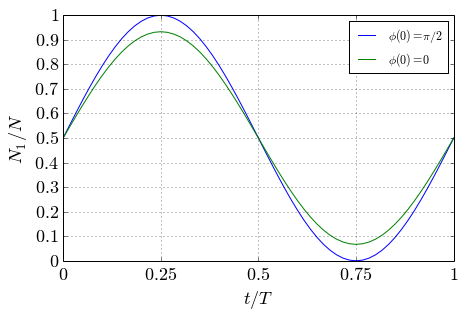

In [19]:
def frac(fraction):
    if fraction == 0.5:
        return '\pi/2$'
    elif fraction == 1/3.:
        return '\pi/3$'
    elif fraction == 1/4.:
        return '\pi/4$'
    elif fraction == 1./6.:
        return '\pi/6$'
    elif fraction == 0.:
        return '0$'
    else:
        return '$'
    
fontsize = 18
time = np.linspace(0, 1., 61)
plt.figure(figsize=(7,4.4))
for indx in range(len(phase_diff_serie)):
    plt.plot(time, list_N1[indx], label='$\phi(0) =' + frac(phase_diff_serie[indx]/np.pi))

    #plt.plot(time, np.sin(time*2.*np.pi)*np.sin(np.pi/3.)*0.5+0.5, 'o', ms=3, label='$0.5(1 + \sin(\pi/3)\sin(\Omega t))$')

plt.xlabel('$t/T$', fontsize=fontsize)
plt.ylabel('$N_1/N$', fontsize=fontsize)
plt.xticks([0,0.25,0.5,0.75,1], ['$0$','$0.25$','$0.5$','$0.75$','$1$'], fontsize=fontsize)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
           ['$0$','$0.1$','$0.2$','$0.3$','$0.4$','$0.5$','$0.6$','$0.7$','$0.8$','$0.9$','$1$',], 
           fontsize=fontsize)
plt.ylim(0,1)
plt.grid()
plt.legend(fontsize=fontsize-6)#,  bbox_to_anchor = (0.5, 0.5))
plt.savefig('density_phi.pdf')
plt.show()


In [8]:
# linear size of the lattice
dim=100
periodic = True
vortex = False
ext_potential = False

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1.7

# start evolution
Rabi_period = np.pi
coupling = 20.
phase_diff = np.pi/6.

list2_N1 = []
list2_N2 = []
gAB_over_g_serie = np.array([0., 0.25, 0.5, 0.75, 1.])
#gAB_over_g_serie = np.array([ 1.])
for gAB_over_g in gAB_over_g_serie:
    N1, N2, phase1, phase2 = density_oscillation(dim, periodic, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                               gAB_over_g, vortex, ext_potential, phase_diff)
    list2_N1.append(N1)
    list2_N2.append(N2)

Start imaginary-time evolution
Energy 0.118343195001   kinetic energy: -2.65578016604e-10
Energy 0.118343195001   kinetic energy: -2.65549122974e-10
Energy 0.118343195001   kinetic energy: -2.6556178789e-10
Energy 0.118343195001   kinetic energy: -2.65562562625e-10
Start imaginary-time evolution
Energy 0.118343212507   kinetic energy: -2.65562495585e-10
Energy 0.118343212507   kinetic energy: -2.65564875578e-10
Energy 0.118343212507   kinetic energy: -2.65559849792e-10
Energy 0.118343212507   kinetic energy: -2.65564978835e-10
Start imaginary-time evolution
Energy 0.118343230014   kinetic energy: -2.65544131848e-10
Energy 0.118343230013   kinetic energy: -2.65578170587e-10
Energy 0.118343230014   kinetic energy: -2.6554578177e-10
Energy 0.118343230013   kinetic energy: -2.65582663031e-10
Start imaginary-time evolution
Energy 0.11834324752   kinetic energy: -2.65609988892e-10
Energy 0.11834324752   kinetic energy: -2.65557114914e-10
Energy 0.11834324752   kinetic energy: -2.65578652361e

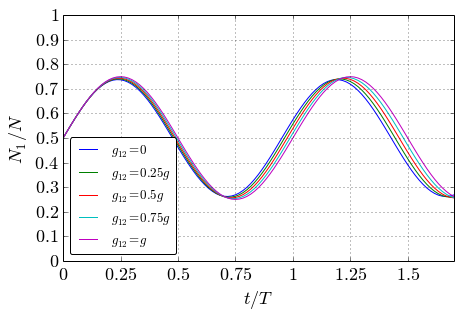

In [20]:
def frac(fraction):
    if fraction == 0.:
        return '0$'
    elif fraction == .25:
        return '0.25 g$'
    elif fraction == .5:
        return '0.5 g$'
    elif fraction == .75:
        return '0.75 g$'
    elif fraction == 1.:
        return 'g$'
    else:
        return '$'
    
fontsize = 18
time = np.linspace(0, 1.7, 103)
plt.figure(figsize=(7,4.4))
for indx in range(len(gAB_over_g_serie)):
    plt.plot(time, list2_N1[indx], label='$g_{12} =' + frac(gAB_over_g_serie[indx]))


plt.xlabel('$t/T$', fontsize=fontsize)
plt.ylabel('$N_1/N$', fontsize=fontsize)
plt.xticks([0,0.25,0.5,0.75,1, 1.25, 1.5], ['$0$','$0.25$','$0.5$','$0.75$','$1$','$1.25$','$1.5$'], fontsize=fontsize)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
           ['$0$','$0.1$','$0.2$','$0.3$','$0.4$','$0.5$','$0.6$','$0.7$','$0.8$','$0.9$','$1$',], 
           fontsize=fontsize)
plt.xlim(0,1.7)
plt.grid()
plt.legend(fontsize=fontsize-5, loc=0, fancybox=True)
plt.savefig('density_g12.pdf')
plt.show()

fig 8

In [24]:
# linear size of the lattice
dim=100
periodic = False
vortex = False
ext_potential = True

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1.

# start evolution
Rabi_period = np.pi
coupling = 20.
phase_diff = np.pi/3.
gAB_over_g = 1.
N1, N2, phase1, phase2 = density_oscillation(dim, periodic, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                               gAB_over_g, vortex, ext_potential, phase_diff)

eta = np.array(N2) - np.array(N1)
phi = np.array(phase2) - np.array(phase1)

Start imaginary-time evolution
Energy 5.55009985437   kinetic energy: 0.215488390015
Energy 4.67565336675   kinetic energy: 0.290945856464
Energy 4.39730523929   kinetic energy: 0.339917726596
Energy 4.28348380186   kinetic energy: 0.372071584528


In [25]:

def d_eta_dt(eta, phi):
    return 2*np.pi/Rabi_period * np.sqrt(1. - eta**2) * np.sin(phi)
def d_phi_dt(eta, phi):
    return - 2*np.pi/Rabi_period * eta / np.sqrt(1. - eta**2) * np.cos(phi)

_d_eta_dt = d_eta_dt(eta, phi)
_d_phi_dt = d_phi_dt(eta, phi)

d_eta_dt = (np.roll(eta[0:60], -1) - np.roll(eta[0:60], 1)) / (2.* Rabi_period/60)
d_eta_dt = np.insert(d_eta_dt, len(d_eta_dt), d_eta_dt[0])
phi_diff = np.roll(phi, -1) - np.roll(phi, 1)
for i in range(len(phi_diff)):
    if np.absolute(phi_diff[i]) > np.pi:
        phi_diff[i] -= np.sign(phi_diff[i]) * 2*np.pi 
d_phi_dt = phi_diff / (2.* Rabi_period/60)


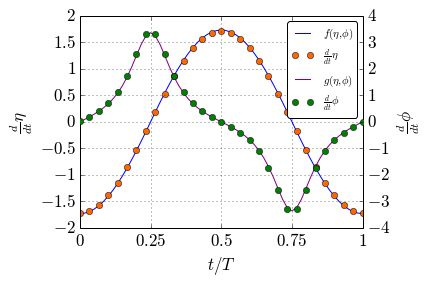

In [60]:
fontsize = 17
time = np.linspace(0, 1., 61)
plt.figure(figsize=(7,4.4))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(time, _d_eta_dt, 'b', label='$f(\eta, \phi)$')
lns2 = ax1.plot(time[::2], d_eta_dt[::2], 'o', c='#FF6600', label=r'$\frac{d}{dt} \eta$')
lns3 = ax2.plot(time, _d_phi_dt, c='#800080', label='$g(\eta, \phi)$')
lns4 = ax2.plot(time[::2], d_phi_dt[::2], 'go', label=r'$\frac{d}{dt} \phi$')

ax1.set_xlabel('$t/T$', fontsize=fontsize)
ax1.set_ylabel(r'$\frac{d}{dt} \eta$', fontsize=fontsize)
ax2.set_ylabel(r'$\frac{d}{dt} \phi$', fontsize=fontsize)

# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=fontsize-6, fancybox=True)

ax1.set_xticks([0,0.25,0.5,0.75,1])
ax1.set_xticklabels(['$0$','$0.25$','$0.5$','$0.75$','$1$'], fontsize=fontsize)
ax1.set_yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
ax1.set_yticklabels(['$-2$','$-1.5$','$-1$','$-0.5$','$0$','$0.5$','$1$','$1.5$','$2$'], fontsize=fontsize)
ax2.set_yticks([-4,-3,-2,-1,0,1,2,3,4])
ax2.set_yticklabels(['$-4$','$-3$','$-2$','$-1$','$0$','$1$','$2$','$3$','$4$'], fontsize=fontsize)

ax1.grid()
plt.tight_layout()
plt.savefig('density_potential.pdf')
plt.show()

fig 9

In [10]:
# linear size of the lattice
dim=100
periodic = True
vortex = False
ext_potential = False

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1

# start evolution
gAB_over_g =1.
Rabi_period = np.pi
coupling = 20.

list3_N1 = []
list3_N2 = []
phase_diff_serie = np.array([1/2., 0.])*np.pi
for phase_diff in phase_diff_serie:
    N1, N2, phase1, phase2 = density_oscillation(dim, periodic, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                               gAB_over_g, vortex, ext_potential, phase_diff)
    list3_N1.append(N1)
    list3_N2.append(N2)

vortex = True
periodic = False
ext_potential = True
N1, N2, phase1, phase2 = density_oscillation(dim, periodic, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                           gAB_over_g, vortex, ext_potential, phase_diff)
list3_N1.append(N1)
list3_N2.append(N2)

Start imaginary-time evolution
Energy 0.118343265026   kinetic energy: -2.65583281862e-10
Energy 0.118343265026   kinetic energy: -2.65562612499e-10
Energy 0.118343265026   kinetic energy: -2.65543120612e-10
Energy 0.118343265026   kinetic energy: -2.65562717116e-10
Start imaginary-time evolution
Energy 0.118343265026   kinetic energy: -2.65583281862e-10
Energy 0.118343265026   kinetic energy: -2.65563611699e-10
Energy 0.118343265026   kinetic energy: -2.65583396087e-10
Energy 0.118343265026   kinetic energy: -2.65562730994e-10
Start imaginary-time evolution
Energy 6.0597669118   kinetic energy: 0.55761272646
Energy 5.23823415914   kinetic energy: 0.654554515761
Energy 4.98518875758   kinetic energy: 0.713230449541
Energy 4.88953906685   kinetic energy: 0.749965880049


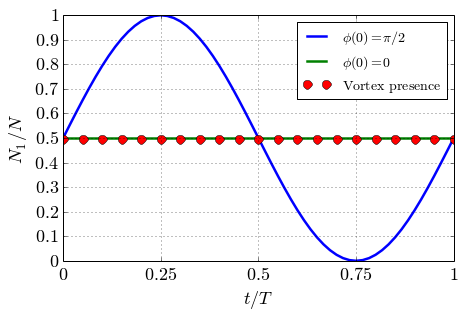

In [23]:
fontsize = 18
time = np.linspace(0, 1., 61)
plt.figure(figsize=(7,4.4))

plt.plot(time, list3_N1[0], label='$\phi(0) = \pi/2$', linewidth=2.5)
plt.plot(time, list3_N1[1], label='$\phi(0) = 0$', linewidth=2.5)
plt.plot(time[::3], list3_N1[len(phase_diff_serie)][::3], 'o', ms=9, label=r'$\mathrm{Vortex \, presence}$')

plt.xlabel('$t/T$', fontsize=fontsize)
plt.ylabel('$N_1/N$', fontsize=fontsize)
plt.xticks([0,0.25,0.5,0.75,1], ['$0$','$0.25$','$0.5$','$0.75$','$1$'], fontsize=fontsize)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
           ['$0$','$0.1$','$0.2$','$0.3$','$0.4$','$0.5$','$0.6$','$0.7$','$0.8$','$0.9$','$1$',], 
           fontsize=fontsize)
plt.ylim(0,1)
plt.grid()
plt.legend(fontsize=fontsize-4, bbox_to_anchor=(1, 1))
plt.savefig('density_vortex.pdf')
plt.show()